Модуль для детекции автомобильного номера на изображении. Нейросеть обучена на изображениях формата .jpg размером 1280\*720 и 1920\*1080. Маски подготовлены с помощью программы LabelImg.

In [ ]:
# коллабные импорты
from google.colab import drive
from google.colab import files


drive.mount('/GD',force_remount=True)

!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/data.zip .
!unzip data.zip

!ls

In [ ]:
import math
import sys
import os
import glob
import shutil
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd

from random import choice, sample
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Получим маски изображений из файлов .xml

In [ ]:
def xml_to_csv(path: str) -> pd.DataFrame:
    """
    Фукнция для создания датафрейма с масками изображений, созданных в
    LabelImg. Принимает на вход путь до папки с .xml файлами.
    Возвращает DataFrame.
    """
    xml_list = []

    for xml_file in tqdm(glob.glob(path + '/*.xml')):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'clas', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)

In [ ]:
masks_xml_path = './masks_xml'
df = xml_to_csv(masks_xml_path)
print('df.shape', df.shape)
df.head(2)

  0%|          | 0/2490 [00:00<?, ?it/s]

df.shape (2952, 8)


,filename,width,height,clas,xmin,ymin,xmax,ymax
0,photo_44994@11-01-2022_20-18-30_0.jpg,1920,1080,number_plate,511,442,640,490
1,photo_38093@04-01-2022_00-00-41_240.jpg,1920,1080,number_plate,618,573,784,621


Создадим изображения с маской в формате .jpg

In [ ]:
def get_mask_from_file(filename: str) -> np.ndarray:
    """
    Получение изображения с маской по датафрейму с координатами.
    Получает имя файла, находит в датафрейме все записи описывающие маску
    и возвращает np.array
    """
    df_file = df[df.filename == filename]
    Y = min(df_file['height'])
    X = min(df_file['width'])
    mask = np.zeros((Y, X, 1))

    for i in range(df_file.shape[0]):
        mask[df_file.iloc[i].ymin: df_file.iloc[i].ymax,
             df_file.iloc[i].xmin: df_file.iloc[i].xmax] = 1

    Y, X = None, None

    return mask

In [ ]:
if not os.path.exists('masks_jpg'):
    !mkdir masks_jpg
else:
    shutil.rmtree('masks_jpg')

filenames = os.listdir('pics_jpg')
annotated_filenames = df.filename.tolist()

for filename in tqdm(filenames):

    if filename in annotated_filenames:
        mask = get_mask_from_file(filename)
    else:
        image = Image.open('pics_jpg/' + filename)
        X, Y = image.size
        mask = np.zeros((Y, X, 1))

    mask = (mask * 255).astype(np.uint8)
    mask = np.squeeze(mask)
    image = Image.fromarray(mask)
    image.save('masks_jpg/' + filename)


shutil.make_archive('masks_jpg', 'zip', '.', 'masks_jpg')
!cp masks_jpg.zip /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg.zip

  0%|          | 0/3755 [00:00<?, ?it/s]

Взглянем на изображения и маски

In [ ]:
filename = filenames[-200]

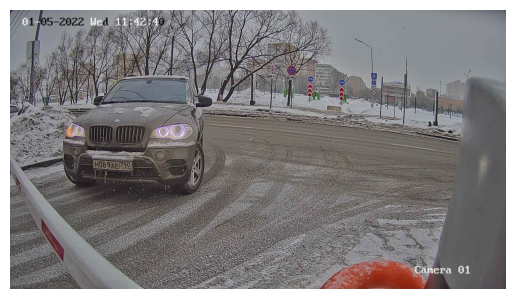

In [ ]:
image = Image.open('pics_jpg/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

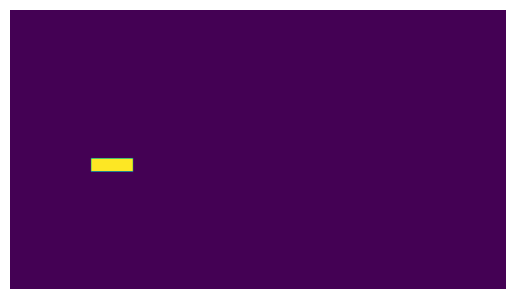

In [ ]:
image = Image.open('masks_jpg/' + filename)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# поделим изображения на train-val-test выборки.
!mkdir pics_jpg_to_train
!mkdir pics_jpg_to_val
!mkdir pics_jpg_to_test

!mkdir masks_jpg_to_train
!mkdir masks_jpg_to_val
!mkdir masks_jpg_to_test


pics_source_path = 'pics_jpg'
masks_source_path = 'masks_jpg'

train_path = '_to_train'
val_path = '_to_val'
test_path = '_to_test'

test_size = 0.2

train_files = filenames[:int(len(filenames) * 0.7)]
val_files = filenames[int(len(filenames) * 0.7):int(len(filenames) * 0.9)]
test_files = filenames[int(len(filenames) * 0.9):]


In [ ]:
# скопируем картинки в соответсвующие папки

for dir in (pics_source_path, masks_source_path):
    for filename in tqdm(train_files):
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + train_path, filename)
        shutil.copyfile(source_file, target_file)

for dir in (pics_source_path, masks_source_path):
    for filename in tqdm(val_files):
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + val_path, filename)
        shutil.copyfile(source_file, target_file)

for dir in (pics_source_path, masks_source_path):
    for filename in tqdm(test_files):
        source_file = os.path.join(dir, filename)
        target_file = os.path.join(dir + test_path, filename)
        shutil.copyfile(source_file, target_file)

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

In [ ]:
# зафиксируем размер изображений, подаваемых на вход нейросети
Y = 480
X = 640

In [ ]:
# создадим генераторы изображений

data_gen_args = dict(rescale=1./255,)

flow_args = dict(classes=[''],
                 target_size = (Y, X),
                 batch_size = 8,
                 class_mode=None,
                 shuffle=False,)

pics_train_datagenerator = ImageDataGenerator(**data_gen_args)
masks_train_datagenerator = ImageDataGenerator(**data_gen_args)

pics_val_datagenerator = ImageDataGenerator(**data_gen_args)
masks_val_datagenerator = ImageDataGenerator(**data_gen_args)

pics_test_datagenerator = ImageDataGenerator(**data_gen_args)
masks_test_datagenerator = ImageDataGenerator(**data_gen_args)

pics_train_datagenerator = pics_train_datagenerator \
    .flow_from_directory('pics_jpg_to_train',
                         **flow_args)
masks_train_datagenerator = masks_train_datagenerator \
    .flow_from_directory('masks_jpg_to_train',
                         color_mode='grayscale',
                         **flow_args)

pics_val_datagenerator = pics_val_datagenerator \
    .flow_from_directory('pics_jpg_to_val',
                         **flow_args)
masks_val_datagenerator = masks_val_datagenerator \
    .flow_from_directory('masks_jpg_to_val',
                         color_mode='grayscale',
                         **flow_args)

pics_test_datagenerator = pics_test_datagenerator \
    .flow_from_directory('pics_jpg_to_test',
                         **flow_args)
masks_test_datagenerator = masks_test_datagenerator \
    .flow_from_directory('masks_jpg_to_test',
                         color_mode='grayscale',
                         **flow_args)

train_generator = zip(pics_train_datagenerator,
                      masks_train_datagenerator)
val_generator = zip(pics_val_datagenerator,
                    masks_val_datagenerator)
test_generator = zip(pics_test_datagenerator,
                     masks_test_datagenerator)

Found 2628 images belonging to 1 classes.
Found 2628 images belonging to 1 classes.
Found 751 images belonging to 1 classes.
Found 751 images belonging to 1 classes.
Found 376 images belonging to 1 classes.
Found 376 images belonging to 1 classes.


Для детекции номеров будем испольовать сеть архитектуры UNet

In [ ]:
# для оценки модели напишем свою версию метрики IoU

def iou(y_true, y_pred):
    """
    Функция для подсчёта метрики IoU на масках изображения
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.keras.backend.sum(y_true_f) \
                                         + tf.keras.backend.sum(y_pred_f) + 1.0)

In [ ]:
# Unet
inputs = Input(shape = (Y, X, 3))

conv1_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv1_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1_1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv2_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv3_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_1)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv4_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_1)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)


up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(pool4)
conc_1 = layers.Concatenate()([conv4_2, up1])
conv_up_1_1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_1_2)
conc_2 = layers.Concatenate()([conv3_2, up2])
conv_up_2_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up3 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_2_2)
conc_3 = layers.Concatenate()([conv2_2, up3])
conv_up_3_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up4 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv_up_3_2)
conc_4 = layers.Concatenate()([conv1_2, up4])
conv_up_4_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv_up_4_1)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv_up_4_2)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), metrics = [iou])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 640, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 640, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

Создадим обратный вызов для тренировки модели

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):

    def __init__(self, patience=5, save_dir=os.getcwd()):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.best_iou = 0
        self.wait = 0
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs['val_iou']
        if current_iou > self.best_iou:
            self.best_iou = current_iou
            self.wait = 0
            self.model.save(os.path.join(self.save_dir, 'PlateDetection(UNet).h5'))
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(' Тренировка остановлена: отсутствие роста IoU на валидационных данных.')


callbacks = [EarlyStopping(patience=10),]

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_files) // flow_args['batch_size'],
                    epochs=200,
                    validation_data=val_generator,
                    validation_steps=len(val_files) // flow_args['batch_size'],
                    callbacks=callbacks)

!cp 'PlateDetection(UNet).h5' /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/'PlateDetection(UNet).h5'

Epoch 1/200
328/328 [==============================] - 152s 387ms/step - loss: 0.0409 - iou: 0.0045 - val_loss: 0.0294 - val_iou: 0.0038
Epoch 2/200
328/328 [==============================] - 135s 396ms/step - loss: 0.0346 - iou: 0.0044 - val_loss: 0.0321 - val_iou: 0.0022
Epoch 3/200
328/328 [==============================] - 129s 394ms/step - loss: 0.0297 - iou: 0.0045 - val_loss: 0.0310 - val_iou: 0.0072
Epoch 4/200
328/328 [==============================] - 129s 394ms/step - loss: 0.0351 - iou: 0.0083 - val_loss: 0.0274 - val_iou: 0.0052
Epoch 5/200
328/328 [==============================] - 129s 394ms/step - loss: 0.0255 - iou: 0.0193 - val_loss: 0.0217 - val_iou: 0.0369
Epoch 6/200
328/328 [==============================] - 129s 394ms/step - loss: 0.0209 - iou: 0.0451 - val_loss: 0.0212 - val_iou: 0.0376
Epoch 7/200
328/328 [==============================] - 129s 394ms/step - loss: 0.0195 - iou: 0.0700 - val_loss: 0.0242 - val_iou: 0.0216
Epoch 8/200
328/328 [====================

In [ ]:
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/'PlateDetection(UNet).h5' .

model = tf.keras.models.load_model('PlateDetection(UNet).h5', compile=False)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=[iou])

Сделаем маску для всех исходных изображений и оценим результат

In [ ]:
def my_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_value = np.sum(intersection) / np.sum(union)
    return iou_value

if not os.path.exists('masks_jpg_predict'):
    !mkdir masks_jpg_predict
else:
    shutil.rmtree('masks_jpg_predict')

path_to_pics_array = []
path_to_true_mask_array = []
path_to_pred_mask_array = []
category_array = []
iou_array = []

for files, category in zip((train_files, val_files, test_files),
                           ('train', 'val', 'test')):

    for pics_name in tqdm(files):

        path_to_pics = os.path.join('pics_jpg', pics_name)
        path_to_true_mask = os.path.join('masks_jpg', pics_name)

        path_to_pics_array.append(path_to_pics)
        path_to_true_mask_array.append(path_to_true_mask)
        category_array.append(category)

        image = Image.open(path_to_pics)
        mask = Image.open(path_to_true_mask)

        size = image.size

        image = np.array(image) / 255.
        mask = np.array(mask) / 255.

        pics_resize = cv2.resize(image,
                                (X, Y),
                                interpolation=cv2.INTER_NEAREST)

        pics_resize = pics_resize.reshape(-1, 480, 640, 3)

        pred_proba = model.predict(pics_resize)

        pred = ((pred_proba > 0.5).astype(int) * 255).reshape(Y, X, 1)

        pred = cv2.resize(pred,
                          size,
                          interpolation=cv2.INTER_NEAREST)

        cur_iou = my_iou(mask, pred.astype('float64'))
        iou_array.append(cur_iou)

        mask_name = pics_name.split('.')[0] + '_mask.jpg'
        path_to_pred_mask = os.path.join('masks_jpg_predict', mask_name)
        path_to_pred_mask_array.append(path_to_pred_mask)

        cv2.imwrite(path_to_pred_mask, pred)

df_result = pd.DataFrame(data={
    'path_to_pics'      : path_to_pics_array,
    'path_to_true_mask' : path_to_true_mask_array,
    'path_to_pred_mask' : path_to_pred_mask_array,
    'category'          : category_array,
    'iou'               : iou_array
})

In [ ]:
df_result.to_csv('detection_result.csv', index=False)
shutil.make_archive('masks_jpg_predict', 'zip', '.', 'masks_jpg_predict')

!cp masks_jpg_predict.zip /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg_predict.zip
!cp detection_result.csv /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/detection_result.csv

In [ ]:
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg.zip .
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg_predict.zip .
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/detection_result.csv .

!unzip masks_jpg.zip
!unzip masks_jpg_predict.zip

In [ ]:
!ls

data.zip	      masks_jpg_predict      masks_xml
detection_result.csv  masks_jpg_predict.zip  pics_jpg
masks_jpg	      masks_jpg.zip	     sample_data


In [ ]:
df_result = pd.read_csv('detection_result.csv')
print('df_result.shape', df_result.shape)
df_result.head(2)

df_result.shape (3755, 5)


,path_to_pics,path_to_true_mask,path_to_pred_mask,category,iou
0,pics_jpg/photo_45269@12-01-2022_01-57-11_0.jpg,masks_jpg/photo_45269@12-01-2022_01-57-11_0.jpg,masks_jpg_predict/photo_45269@12-01-2022_01-57...,train,NaN
1,pics_jpg/photo_44798@11-01-2022_16-35-50_360.jpg,masks_jpg/photo_44798@11-01-2022_16-35-50_360.jpg,masks_jpg_predict/photo_44798@11-01-2022_16-35...,train,0.671911


Осмотрим результаты.

У части изображение значение метрики получается None. Это связано с тем, что на картинке вовсе нет номера и модель его также не обнаружила.

In [ ]:
df_result['iou'].isna().mean()

0.34007989347536616

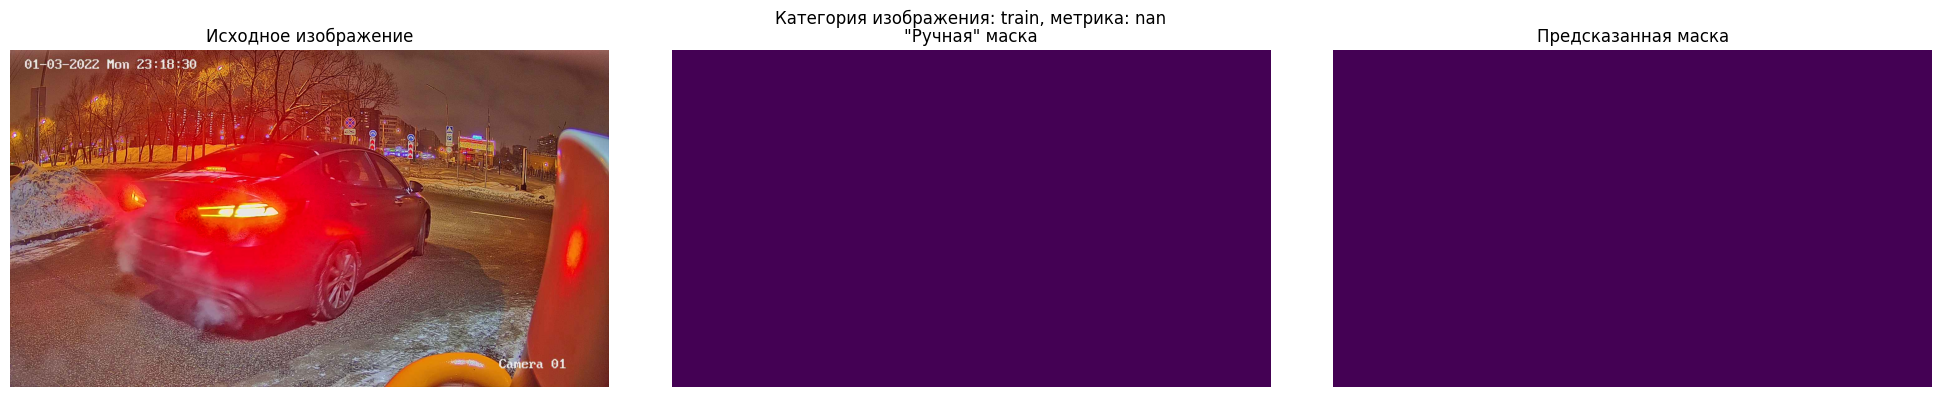

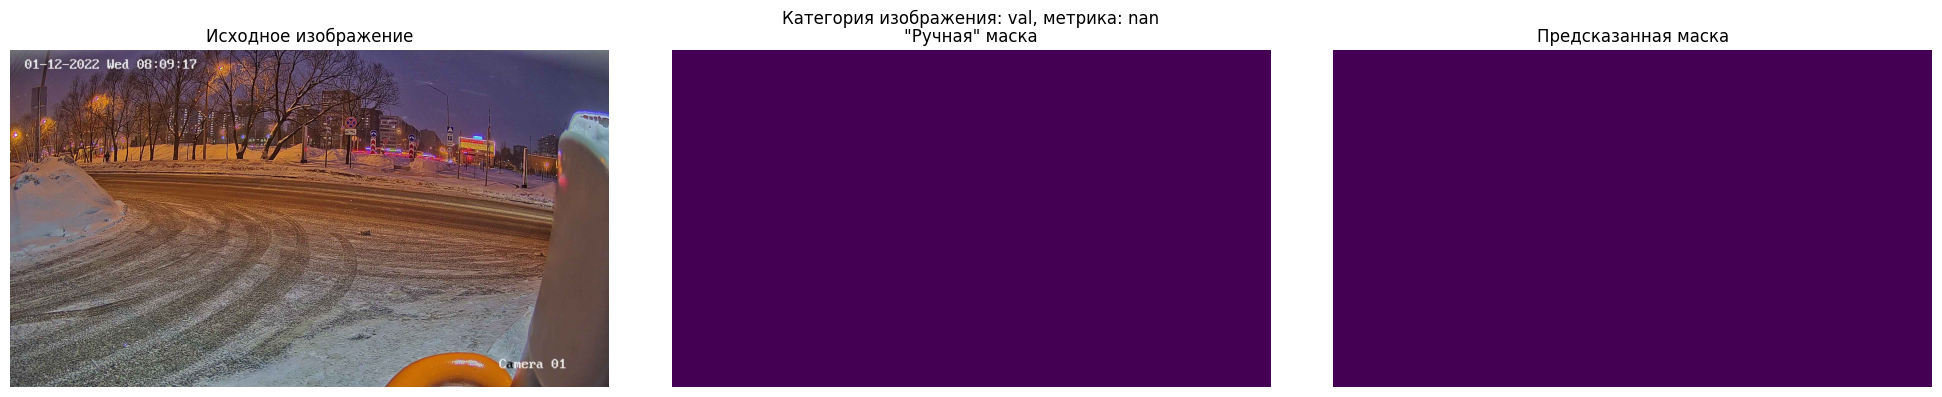

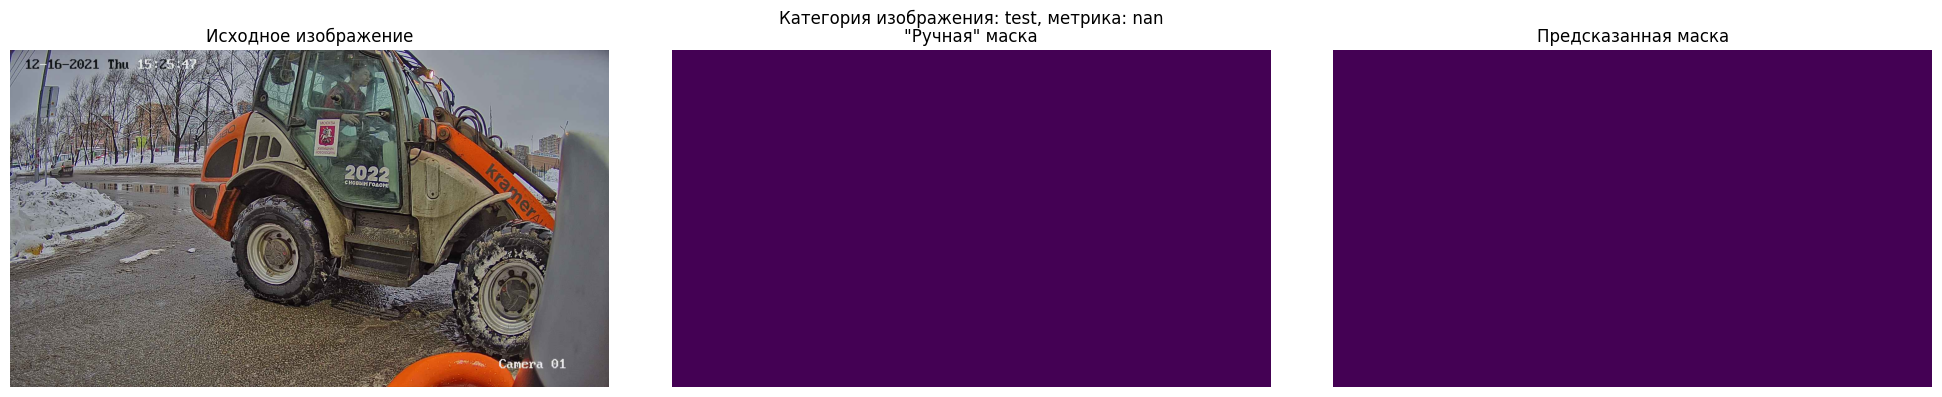

In [ ]:
for category in ('train', 'val', 'test'):

    indexis = df_result[(df_result['iou'].isna()) & (df_result['category'] == category)].index
    ind = choice(indexis)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    fig.suptitle(f'Категория изображения: {category}, метрика: {df_result.loc[ind, "iou"]}')

    ax1.imshow(Image.open(df_result.loc[ind, 'path_to_pics']))
    ax1.set_title('Исходное изображение')
    ax1.axis('off')

    ax2.imshow(Image.open(df_result.loc[ind, 'path_to_true_mask']))
    ax2.set_title('"Ручная" маска')
    ax2.axis('off')

    ax3.imshow(Image.open(df_result.loc[ind, 'path_to_pred_mask']))
    ax3.set_title('Предсказанная маска')
    ax3.axis('off')

    fig.tight_layout()

    plt.show()
    print()

В целом среднее значение метрики по категориям

In [ ]:
for category in ('train', 'val', 'test'):
    print('Категория: ', category, 'Метрика:', round(df_result[df_result['category'] == category]['iou'].mean(), 4))

Категория:  train Метрика: 0.6792
Категория:  val Метрика: 0.6599
Категория:  test Метрика: 0.658


Есть изображения, для которых значение метрики равно 0:

In [ ]:
df_result[df_result['iou'] == 0]['category'].value_counts()

train    77
val      23
test     18
Name: category, dtype: int64

In [ ]:
for category in ('train', 'val', 'test'):

    indexis = sample(list(df_result[(df_result['iou'] == 0) & (df_result['category'] == category)].index), 5)

    for ind in indexis:

        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
        fig.suptitle(f'Категория изображения: {category}, метрика: {df_result.loc[ind, "iou"]}')

        ax1.imshow(Image.open(df_result.loc[ind, 'path_to_pics']))
        ax1.set_title('Исходное изображение')
        ax1.axis('off')

        ax2.imshow(Image.open(df_result.loc[ind, 'path_to_true_mask']))
        ax2.set_title('"Ручная" маска')
        ax2.axis('off')

        ax3.imshow(Image.open(df_result.loc[ind, 'path_to_pred_mask']))
        ax3.set_title('Предсказанная маска')
        ax3.axis('off')

        fig.tight_layout()

        plt.show()
        print()

Посмотрим в целом на некторые худшие и лучшие изображения:

In [ ]:
for category in ('train', 'val', 'test'):

    temp_indexis = list(df_result[(df_result['iou'] > 0) & (df_result['category'] == category)].sort_values(by='iou').index)

    indexis = temp_indexis[:5] + temp_indexis[-5:]

    for ind in indexis:

        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
        fig.suptitle(f'Категория изображения: {category}, метрика: {df_result.loc[ind, "iou"]}')

        ax1.imshow(Image.open(df_result.loc[ind, 'path_to_pics']))
        ax1.set_title('Исходное изображение')
        ax1.axis('off')

        ax2.imshow(Image.open(df_result.loc[ind, 'path_to_true_mask']))
        ax2.set_title('"Ручная" маска')
        ax2.axis('off')

        ax3.imshow(Image.open(df_result.loc[ind, 'path_to_pred_mask']))
        ax3.set_title('Предсказанная маска')
        ax3.axis('off')

        fig.tight_layout()

        plt.show()
        print()

Общее распределение метрики:

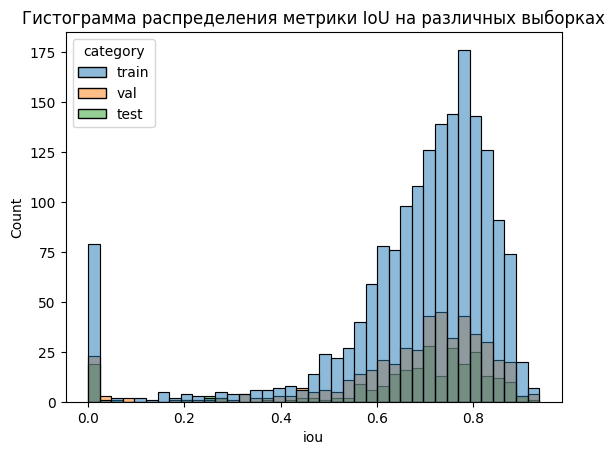

In [ ]:
sns.histplot(data=df_result, x='iou', hue='category')
plt.title('Гистограмма распределения метрики IoU на различных выборках')
plt.show()

Еще раз присмотримся к изображениям, на которых значение метрики получилось 0

In [ ]:
indexis = list(df_result[df_result['iou'] == 0].index)

for ind in tqdm(indexis):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    fig.suptitle(f'Категория изображения: {df_result.loc[ind, "category"]}, метрика: {df_result.loc[ind, "iou"]}')

    ax1.imshow(Image.open(df_result.loc[ind, 'path_to_pics']))
    ax1.set_title('Исходное изображение')
    ax1.axis('off')

    ax2.imshow(Image.open(df_result.loc[ind, 'path_to_true_mask']))
    ax2.set_title('"Ручная" маска')
    ax2.axis('off')

    ax3.imshow(Image.open(df_result.loc[ind, 'path_to_pred_mask']))
    ax3.set_title('Предсказанная маска')
    ax3.axis('off')

    fig.tight_layout()

    plt.show()
    print()